# Note on Experimental Design
### simulation-based demo
Demonstration of the differences of block and fast randomized designs, in terms of power. This demo intends to illustrate that block designs are inherently a lot stronger if what you want is statistical power for detection.

### exercise (0 pt)
The simulation parameter `fast_vs_slow_multiplication_factor`, defined below, determines how strong the fast event-related design's neural activations are relative to the slow block design activations. In real life they are equally strong, and thus this value would be 1. But in our simulations, we can modulate the strenght of the fast design, to provide an indication of the relative strength of activation detection power of the two designs, as quantified by the T statistic we have already learned to calculate. 

Your goal in this exercise, is to try to find the integer `fast_vs_slow_multiplication_factor` that will come closest to equate the T stats for the different designs. Please feel free to also play around with the other parameters in the simulations.

In [161]:
import numpy as np
import scipy as sp
import nibabel as nb

import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline 

### Parameters
Below are the parameters that define the simulation. 

In [162]:
# parameters
simulation_frequency = 40 # Hz
nr_signal_timepoints = 5000

# define the timepoints neatly
timepoints_in_seconds = np.linspace(0, nr_signal_timepoints/simulation_frequency, nr_signal_timepoints)

# determine at what speed are we measuring the BOLD signal
measurement_TR = 2.0
simulation_timepoints_in_TR = int(measurement_TR * simulation_frequency)
nr_signal_timepoints_in_BOLD = nr_signal_timepoints / simulation_timepoints_in_TR

# We also set the noise level for both neural activations and bold measurements
neural_noise_level = 0.75
BOLD_noise_level = 25.0

# We implement a factor that can scale how strong the neural activity is 
# in the fast design, relative to the slow design.
fast_vs_slow_multiplication_factor = 1.0

### HRF
And of course, we'll define a standard HRF

In [163]:
def double_gamma(x, a1 = 6, a2 = 12, b1 = 0.9, b2 = 0.9, c = 0.35):
	d1 = a1 * b1
	d2 = a2 * b2
	return np.array([(t/(d1))**a1 * np.exp(-(t-d1)/b1) - c*(t/(d2))**a2 * np.exp(-(t-d2)/b2) for t in x])

# we evaluate the HRF functions on a thousand timepoints between 0 and 25 s
hrf_timepoints_to_evaluate = np.linspace(0,25,simulation_frequency * 25)
hrf = double_gamma(hrf_timepoints_to_evaluate, a1 = 6, a2 = 12, b1 = 0.9, b2 = 0.9, c = 0.35)
hrf /= hrf.max()

### Fast "event-related" and slow "block" designs
Below, we define the fast and slow designs, and show their neural activations and BOLD responses, all without added noise.

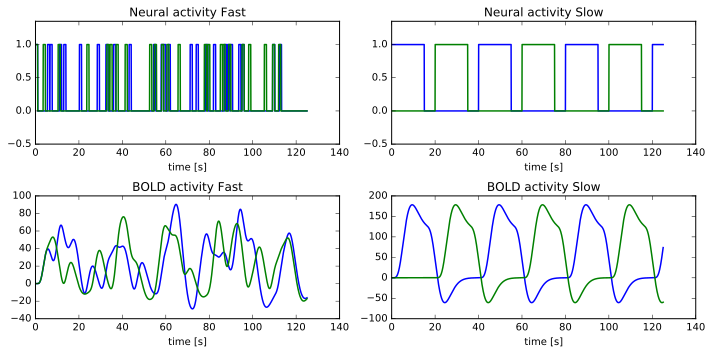

In [164]:
# the fast event-related design's neural activations:
fast_experiment_neural_signal_1 = np.concatenate([np.r_[np.ones(simulation_frequency),np.zeros(int(np.random.exponential(simulation_frequency * 4)))] for x in range(200)])[:nr_signal_timepoints]
fast_experiment_neural_signal_2 = np.concatenate([np.r_[np.ones(simulation_frequency),np.zeros(int(np.random.exponential(simulation_frequency * 4)))] for x in range(200)])[:nr_signal_timepoints]
# the slow block design's neural activations:
slow_experiment_neural_signal_1 = np.roll(np.tile(np.r_[np.ones(600), np.zeros(1000)], 20), 0)[:nr_signal_timepoints]
slow_experiment_neural_signal_2 = np.roll(np.tile(np.r_[np.ones(600), np.zeros(1000)], 20), 800)[:nr_signal_timepoints]

# the resulting bold timecourses:
fast_BOLD_timecourse_1 = np.convolve(fast_experiment_neural_signal_1, hrf, 'full')[:nr_signal_timepoints]
fast_BOLD_timecourse_2 = np.convolve(fast_experiment_neural_signal_2, hrf, 'full')[:nr_signal_timepoints]
slow_BOLD_timecourse_1 = np.convolve(slow_experiment_neural_signal_1, hrf, 'full')[:nr_signal_timepoints]
slow_BOLD_timecourse_2 = np.convolve(slow_experiment_neural_signal_2, hrf, 'full')[:nr_signal_timepoints]

f = plt.figure(figsize = (10,5))
s = f.add_subplot(221)
plt.title('Neural activity Fast')

plt.plot(timepoints_in_seconds, fast_experiment_neural_signal_1, lw = 1.5)
plt.plot(timepoints_in_seconds, fast_experiment_neural_signal_2, lw = 1.5)

plt.xlabel('time [s]')
s.set_ylim([-0.5,1.35])

s = f.add_subplot(222)
plt.title('Neural activity Slow')

plt.plot(timepoints_in_seconds, slow_experiment_neural_signal_1, lw = 1.5)
plt.plot(timepoints_in_seconds, slow_experiment_neural_signal_2, lw = 1.5)

plt.xlabel('time [s]')
s.set_ylim([-0.5,1.35])

s = f.add_subplot(223)
plt.title('BOLD activity Fast')

plt.plot(timepoints_in_seconds, fast_BOLD_timecourse_1, lw = 1.5)
plt.plot(timepoints_in_seconds, fast_BOLD_timecourse_2, lw = 1.5)

plt.xlabel('time [s]')
# s.set_ylim([-1.5,3.35])

s = f.add_subplot(224)
plt.title('BOLD activity Slow')

plt.plot(timepoints_in_seconds, slow_BOLD_timecourse_1, lw = 1.5)
plt.plot(timepoints_in_seconds, slow_BOLD_timecourse_2, lw = 1.5)

plt.xlabel('time [s]')
# s.set_ylim([-1.5,3.35])
plt.tight_layout()

### Noise added
Below, we add noise to the simulations, and plot the result of these noise additions at the frequency of measurement, as defined by the `measurement_TR` parameter way, way above in the notebook. 

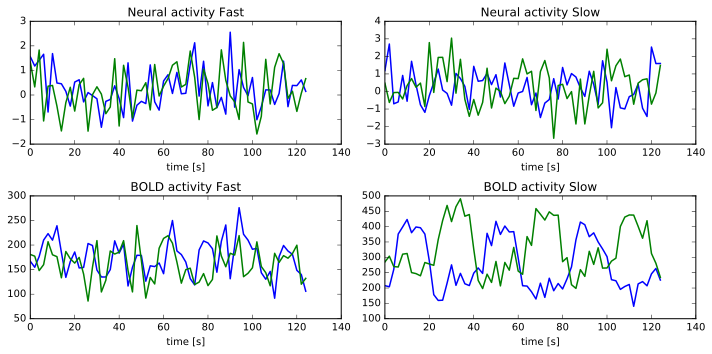

In [165]:
# the fast event-related design's neural activations:
fast_experiment_neural_signal_1_noise = fast_experiment_neural_signal_1 * fast_vs_slow_multiplication_factor + np.random.randn(nr_signal_timepoints) * neural_noise_level
fast_experiment_neural_signal_2_noise = fast_experiment_neural_signal_2 * fast_vs_slow_multiplication_factor + np.random.randn(nr_signal_timepoints) * neural_noise_level
# the slow block design's neural activations:
slow_experiment_neural_signal_1_noise = slow_experiment_neural_signal_1 + np.random.randn(nr_signal_timepoints) * neural_noise_level
slow_experiment_neural_signal_2_noise = slow_experiment_neural_signal_2 + np.random.randn(nr_signal_timepoints) * neural_noise_level

# 'random' intercepts:
intercepts = [150, 134, 230, 278]
# the resulting bold timecourses:
fast_BOLD_timecourse_1_noise = intercepts[0] + np.convolve(fast_experiment_neural_signal_1_noise, hrf, 'full')[:nr_signal_timepoints] + np.random.randn(nr_signal_timepoints) * BOLD_noise_level
fast_BOLD_timecourse_2_noise = intercepts[1] + np.convolve(fast_experiment_neural_signal_2_noise, hrf, 'full')[:nr_signal_timepoints] + np.random.randn(nr_signal_timepoints) * BOLD_noise_level
slow_BOLD_timecourse_1_noise = intercepts[2] + np.convolve(slow_experiment_neural_signal_1_noise, hrf, 'full')[:nr_signal_timepoints] + np.random.randn(nr_signal_timepoints) * BOLD_noise_level
slow_BOLD_timecourse_2_noise = intercepts[3] + np.convolve(slow_experiment_neural_signal_2_noise, hrf, 'full')[:nr_signal_timepoints] + np.random.randn(nr_signal_timepoints) * BOLD_noise_level

f = plt.figure(figsize = (10,5))
s = f.add_subplot(221)
plt.title('Neural activity Fast')

plt.plot(timepoints_in_seconds[::simulation_timepoints_in_TR], fast_experiment_neural_signal_1_noise[::simulation_timepoints_in_TR], lw = 1.5)
plt.plot(timepoints_in_seconds[::simulation_timepoints_in_TR], fast_experiment_neural_signal_2_noise[::simulation_timepoints_in_TR], lw = 1.5)

plt.xlabel('time [s]')
# s.set_ylim([-0.5,1.35])

s = f.add_subplot(222)
plt.title('Neural activity Slow')

plt.plot(timepoints_in_seconds[::simulation_timepoints_in_TR], slow_experiment_neural_signal_1_noise[::simulation_timepoints_in_TR], lw = 1.5)
plt.plot(timepoints_in_seconds[::simulation_timepoints_in_TR], slow_experiment_neural_signal_2_noise[::simulation_timepoints_in_TR], lw = 1.5)

plt.xlabel('time [s]')
# s.set_ylim([-0.5,1.35])

s = f.add_subplot(223)
plt.title('BOLD activity Fast')

plt.plot(timepoints_in_seconds[::simulation_timepoints_in_TR], fast_BOLD_timecourse_1_noise[::simulation_timepoints_in_TR], lw = 1.5)
plt.plot(timepoints_in_seconds[::simulation_timepoints_in_TR], fast_BOLD_timecourse_2_noise[::simulation_timepoints_in_TR], lw = 1.5)

plt.xlabel('time [s]')
# s.set_ylim([-1.5,3.35])

s = f.add_subplot(224)
plt.title('BOLD activity Slow')

plt.plot(timepoints_in_seconds[::simulation_timepoints_in_TR], slow_BOLD_timecourse_1_noise[::simulation_timepoints_in_TR], lw = 1.5)
plt.plot(timepoints_in_seconds[::simulation_timepoints_in_TR], slow_BOLD_timecourse_2_noise[::simulation_timepoints_in_TR], lw = 1.5)

plt.xlabel('time [s]')
# s.set_ylim([-1.5,3.35])
plt.tight_layout()

In the plots above, you already see which of the two designs looks noisier, and which looks like it gives 'clearer' results, right? Which one is it? We will now test our intuition.

### Fitting the Fast Design
First, we fit the fast design. Inspect the beta values.

In [166]:
# we first have to create a design matrix, by putting the different expectations together, and
# again adding the ones for fitting the intercept.
fast_design_matrix = np.array([fast_BOLD_timecourse_1[::simulation_timepoints_in_TR], fast_BOLD_timecourse_2[::simulation_timepoints_in_TR], np.ones(nr_signal_timepoints)[::simulation_timepoints_in_TR]])
fast_fmri_data = np.array([fast_BOLD_timecourse_1_noise[::simulation_timepoints_in_TR], fast_BOLD_timecourse_2_noise[::simulation_timepoints_in_TR]]).squeeze()

# first, we perform our analysis on the multimodal voxel.
# we again use the linear regression function
fast_betas, fast_sse, _r, _svs = np.linalg.lstsq(fast_design_matrix.T, fast_fmri_data.T )

print '######## Fitting results #########'
print ''
print 'the different voxels: '
print '               [1\t\t2]'
print 'Beta 1         ' + str(fast_betas[0])
print 'Beta 2         ' + str(fast_betas[1])
print 'Beta intercept ' + str(fast_betas[2])

######## Fitting results #########

the different voxels: 
               [1		2]
Beta 1         [ 0.94729801  0.11677826]
Beta 2         [ 0.02153318  0.78066314]
Beta intercept [ 151.65648164  142.55143881]


### Fast Design Statistics 
As before, we calculate the T and p values of the different voxels' signals.

In [167]:
# contrast vector and degrees of freedom
One_gt_Two = np.matrix([-1,1,0])
design_matrix_rank = np.linalg.matrix_rank(fast_design_matrix)
df = nr_signal_timepoints_in_BOLD - design_matrix_rank

# some linear algebra, the C (XX^T)-1 CT part.
contrast_in_dm = np.array(One_gt_Two * np.linalg.pinv(np.dot(fast_design_matrix, fast_design_matrix.T)) * One_gt_Two.T).squeeze()

# to standard errors, using the mean, overall squared error, from the sum of squared residuals _sse
standard_errors = np.sqrt((fast_sse/df) * contrast_in_dm)

# T-statistics for the relevant regressors
T_stats = np.squeeze(np.array(np.dot(One_gt_Two, fast_betas) / standard_errors))

# and convert these to p-values using the T distribution:
from scipy.stats import t
p_vals = np.squeeze([t.cdf(-np.abs(x), df) for x in T_stats])

print '######## Statistics #########'
for p, t, s in zip(p_vals, T_stats, ['1','2']):
    print 'FAST %s: T-statistic: %2.4f, p-value is %1.10f' %(s,t,p)

######## Statistics #########
FAST 1: T-statistic: -4.0765, p-value is 0.0000693345
FAST 2: T-statistic: 2.7354, p-value is 0.0041082851


### Fitting the Slow Design
Now, we fit the Slow design. Inspect the beta values.

In [168]:
# we first have to create a design matrix, by putting the different expectations together, and
# again adding the ones for fitting the intercept.
slow_design_matrix = np.array([slow_BOLD_timecourse_1[::simulation_timepoints_in_TR], slow_BOLD_timecourse_2[::simulation_timepoints_in_TR], np.ones(nr_signal_timepoints)[::simulation_timepoints_in_TR]])
slow_fmri_data = np.array([slow_BOLD_timecourse_1_noise[::simulation_timepoints_in_TR], slow_BOLD_timecourse_2_noise[::simulation_timepoints_in_TR]]).squeeze()

# first, we perform our analysis on the multimodal voxel.
# we again use the linear regression function
slow_betas, slow_sse, _r, _svs = np.linalg.lstsq(slow_design_matrix.T, slow_fmri_data.T )

print '######## Fitting results #########'
print ''
print 'the different voxels: '
print '               [1\t\t2]'
print 'Beta 1         ' + str(slow_betas[0])
print 'Beta 2         ' + str(slow_betas[1])
print 'Beta intercept ' + str(slow_betas[2])
# print slow_betas

######## Fitting results #########

the different voxels: 
               [1		2]
Beta 1         [ 0.98457013 -0.02519071]
Beta 2         [-0.08436261  1.01033236]
Beta intercept [ 236.04517503  282.13728008]


### Slow Design Statistics 
As before, we calculate the T and p values of the different voxels' signals.

In [169]:
# contrast vector and degrees of freedom
One_gt_Two = np.matrix([-1,1,0])
design_matrix_rank = np.linalg.matrix_rank(slow_design_matrix)
df = nr_signal_timepoints_in_BOLD - design_matrix_rank

# some linear algebra, the C (XX^T)-1 CT part.
contrast_in_dm = np.array(One_gt_Two * np.linalg.pinv(np.dot(slow_design_matrix, slow_design_matrix.T)) * One_gt_Two.T).squeeze()

# to standard errors, using the mean, overall squared error, from the sum of squared residuals _sse
standard_errors = np.sqrt((slow_sse/df) * contrast_in_dm)

# T-statistics for the relevant regressors
T_stats = np.squeeze(np.array(np.dot(One_gt_Two, slow_betas) / standard_errors))

# and convert these to p-values using the T distribution:
from scipy.stats import t
p_vals = np.squeeze([t.cdf(-np.abs(x), df) for x in T_stats])

print '######## Statistics #########'
for p, t, s in zip(p_vals, T_stats, ['1','2']):
    print 'SLOW %s: T-statistic: %2.4f, p-value is %1.10f' %(s,t,p)

######## Statistics #########
SLOW 1: T-statistic: -20.3329, p-value is 0.0000000000
SLOW 2: T-statistic: 17.6419, p-value is 0.0000000000
